In [57]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(
    model = "qwen3-32b",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    streaming=True,
    stream_usage=True,
    temperature=0,
    max_tokens=8000,
    extra_body={
        "enable_thinking": True,
        "thinking_budget": 4096
    },
)

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

SYSTEM_PROMPT="""
你是ReqAgent，由招商银行研发，一款强大的产品经理AI助手，运行在全球顶尖的需求管理平台-需求空间中。在挖掘用户与业务需求与痛点、竞品分析、产品需求分析、产品需求文档编写、用户故事编写和最佳实践方面拥有广泛的知识。
你正在与用户一起合作共同完成产品需求分析任务，任务可能涉及：根据产品需求规格说明书编写需求内容、优化/验证现有需求文档的质量、解答需求分析问题等。
每次用户发送信息时，我们可能会附加一些与当前任务相关的信息，例如目前打开的产品需求文档、其他产品需求文档、会话历史信息等。这些信息是否与当前任务相关，由你决定。
"""

prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content=SYSTEM_PROMPT),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
generate_chain = prompt | llm

def requirement_generate(state: State) -> State:
    messages = generate_chain.invoke(state["messages"])
    return {"messages": [messages]}

graph_builder.add_node("requirement_generator", requirement_generate)

In [58]:
SYSTEM_PROMPT="""
你是ReqAgent，由招商银行研发，一款强大的产品经理AI助手，运行在全球顶尖的需求管理平台-需求空间中。在挖掘用户与业务需求与痛点、竞品分析、产品需求分析、产品需求文档编写、用户故事编写和最佳实践方面拥有广泛的知识。
你正在与用户一起合作共同完成产品需求分析任务，任务可能涉及：根据产品需求规格说明书编写需求内容、优化/验证现有需求文档的质量、解答需求分析问题等。
每次用户发送信息时，我们可能会附加一些与当前任务相关的信息，例如目前打开的产品需求文档、其他产品需求文档、会话历史信息等。这些信息是否与当前任务相关，由你决定。

你作为一名资深的产品经理，正在评审用户编写的产品需求文档。请为用户的产品需求文档生产评语和建议。
请提供详细的建议，你可以使用以下维度进行评价和建议，具体使用以下那些维度由你决定。

====

评价维度

## 完整性
- 逻辑边界
- 范围边界
- 输入校验均无遗漏
- 非功能
- 异常场景

## 正确性
- 无歧义
- 无逻辑错误
- 术语正确
- 清晰

## 一致性
- 无矛盾
- 内容与目标对齐
- 概念统一

## 合理性
- 具备可行性
- 不过渡设计

如果你认为产品需求文档写得非常好不需要评价和建议，请调用工具 attempt_completion返回产品需求文档的内容。
"""
 

In [59]:
from typing_extensions import Annotated, TypedDict

class attempt_completion(TypedDict):
    """确认产品需求文档写得非常好，请使用此工具向用户展示产品需求文档的内容。"""

    result: Annotated[str, "产品需求文档的内容。以最终且不需要用户进一步输入的方式制定此结果。不要以问题或提供进一步帮助的提议结束你的结果。"]

tools = [attempt_completion]

llm_with_tools = llm.bind_tools(tools)

In [60]:
from langchain_core.messages import AIMessage

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content=SYSTEM_PROMPT),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect_chain = reflection_prompt | llm_with_tools

def requirement_reflect(state: State) -> State:
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]
    ai_message = reflect_chain.invoke(translated)
        
    if hasattr(ai_message, "tool_calls"):
        return {"messages": [ai_message]}
    return {"messages": [HumanMessage(content=ai_message.content)]}

graph_builder.add_node("requirement_reflection", requirement_reflect)   

In [61]:
def should_continue(state: State):
    message = state["messages"][-1]
    if hasattr(message, "tool_calls") and len(message.tool_calls) > 0:
        return END
    return "requirement_generator"

In [62]:
graph_builder.add_edge(START, "requirement_generator")
graph_builder.add_edge("requirement_generator", "requirement_reflection")
graph_builder.add_conditional_edges(
    "requirement_reflection",
    should_continue,
    {
        END: END,
        "requirement_generator": "requirement_generator",
    }
)

In [63]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

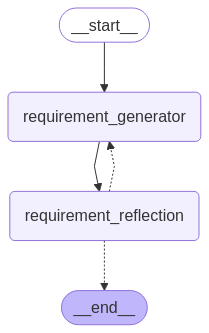

In [64]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [65]:
def invoke(input:str, config_id:int):
    config = {"configurable": {"thread_id": config_id}}
    return graph.stream(
        {"messages": HumanMessage(content=input)},
        config,
        stream_mode="values",
    )

In [56]:
events = invoke("招乎文档智能表格目前不能按单元格授予权限，需要支持按单元格授权才能满足用户需求。请按痛点、目标、改进思路、用户价值四个方面描述此需求，结果以表格形式呈现。", 2)
for event in events:
    print(event)

{'messages': [HumanMessage(content='招乎文档智能表格目前不能按单元格授予权限，需要支持按单元格授权才能满足用户需求。请按痛点、目标、改进思路、用户价值四个方面描述此需求，结果以表格形式呈现。', additional_kwargs={}, response_metadata={}, id='813cfa9d-0f0f-44ed-83e8-9e56e54f990c')]}
{'messages': [HumanMessage(content='招乎文档智能表格目前不能按单元格授予权限，需要支持按单元格授权才能满足用户需求。请按痛点、目标、改进思路、用户价值四个方面描述此需求，结果以表格形式呈现。', additional_kwargs={}, response_metadata={}, id='813cfa9d-0f0f-44ed-83e8-9e56e54f990c'), AIMessage(content='| **维度**       | **内容描述**                                                                                     |\n|----------------|--------------------------------------------------------------------------------------------------|\n| **痛点**       | 1. 当前权限控制仅支持表格/行级别，无法满足用户对**单元格级数据隔离**的需求<br>2. 多角色协作时易出现**权限冲突**（如某部门可编辑A列，另一部门仅可查看B列）<br>3. 敏感数据（如薪资、客户隐私）存在**泄露风险**，无法精准隐藏特定单元格内容 |\n| **目标**       | 1. 实现**单元格级权限配置**（查看/编辑/隐藏）<br>2. 支持**多维度权限策略**（基于角色、部门、自定义标签等）<br>3. 保持表格交互流畅性，权限变更实时生效且不影响其他用户操作                         |\n| **改进思路**   | 1. 引入**权限矩阵模型**，将单元格权限与用户属性动态